<a href="https://colab.research.google.com/github/nan-park/section2_project/blob/main/data_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf # 한글 폰트 깨짐 해결

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [3]:
from google.colab import files
files.upload();
# model_data.csv
# model_data_stationary.csv (model_data.csv를 정상성 갖도록 변환한 데이터)

Saving model_data.csv to model_data (1).csv
Saving model_data_stationary.csv to model_data_stationary (1).csv


In [4]:
url1 = 'model_data.csv'
url2 = 'model_data_stationary.csv'
df = pd.read_csv(url1, index_col=0)
df_stationary = pd.read_csv(url2, index_col=0)

# **데이터 모델링**

먼저 시계열 데이터임을 무시하고, 각각의 시계열 데이터(row)는 다른 시간대 데이터와 독립적이라고 가정하고 모델링을 해보려고 한다.<br>
즉, 자기상관관계(autocorrelation)를 갖지 않는다고 가정한다.<br>
그러면 일반적 선형회귀나 랜덤포레스트, XGBRegressor 등을 사용할 수 있다.

타겟 설정 -> 소비자물가상승률(%)

In [5]:
target = '소비자물가상승률(%)'
features = df.columns.tolist()
features.remove(target)

X = df[features]
y = df[target]

In [6]:
len(y)  # 데이터 개수 265개

265

훈련/테스트 비율을 8:2로 잡고, 
훈련 데이터를 cross validation(cv=5)으로 한다.(데이터 개수가 적음)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- 기준모델(Baseline model)

타겟의 평균값을 기준모델로 잡는다.

In [8]:
y_test_pred_base = [y_train.mean()] * len(y_test)
# 회귀 평가지표
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print('validation data eval(Baseline)')
print(f'mae : {mean_absolute_error(y_test, y_test_pred_base).round(5)}')
print(f'mse : {mean_squared_error(y_test, y_test_pred_base).round(5)}')
print(f'rmse : {(mean_squared_error(y_test, y_test_pred_base)**0.5).round(5)}')
print(f'r2 score : {r2_score(y_test, y_test_pred_base)}')

validation data eval(Baseline)
mae : 1.00976
mse : 1.6075
rmse : 1.26787
r2 score : -0.015812847536039953


- 다중선형회귀모델(1차)

In [9]:
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import cross_val_score

# 회귀평가지표: neg_mean_absolute_error(-0.4727), r2(0.7), neg_mean_squared_error(-0.49253)
linear = LinearRegression(normalize=True)
linear_rmse_score = -cross_val_score(linear, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5).mean()
print(f'Linear model rmse score : {linear_rmse_score.round(5)}')

Linear model rmse score : 0.70049


- 랜덤포레스트 회귀(RandomForestRegressor)

In [10]:
from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor( # 하이퍼파라미터 모두 default
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    n_jobs=-1,
    random_state=42
)
random_mae_score = -cross_val_score(randomforest, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5).mean()
print(f'RandomForest model rmse score : {random_mae_score.round(5)}')

RandomForest model rmse score : 0.5379


하이퍼파라미터 튜닝(직접 튜닝)

In [11]:
randomforest_tune = RandomForestRegressor( # 하이퍼파라미터 모두 default
    n_estimators=100,
    criterion='squared_error',
    max_depth=12, # default None
    min_samples_split=2,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    n_jobs=-1,
    random_state=42
)
random_tune_mae_score = -cross_val_score(randomforest_tune, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5).mean()
print(f'RandomForest model rmse score : {random_tune_mae_score.round(5)}')

RandomForest model rmse score : 0.53682


파라미터에 따라서 크게 달라지지는 않는 모습.

 - XGBRegressor 회귀

In [12]:
from xgboost import XGBRegressor
xgb = XGBRegressor( # 하이퍼파라미터 모두 default
    booster='gblinear',
    objective='reg:linear',
    eval_metric='rmse',
    max_depth=6,
    learning_rate=0.01,
    colsample_bytree=1,
    n_jobs=-1,
)
xgb_rmse_score = -cross_val_score(xgb, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5).mean()
print(f'XGB model rmse score : {xgb_rmse_score.round(5)}')

XGB model rmse score : 1.00519


하이퍼파라미터 튜닝

In [13]:
xgb_tune = XGBRegressor( # 하이퍼파라미터 모두 default
    booster='gblinear',
    objective='reg:linear',
    eval_metric='rmse',
    max_depth=6,  # 변화 없음
    learning_rate=0.23,
    n_jobs=-1,
    colsample_bytree=1, # 변화없음
    gamma=0,  # 변화 없음
    subsample=0.5,  # 변화없음
)
xgb_tune_rmse_score = -cross_val_score(xgb_tune, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5).mean()
print(f'XGB model rmse score : {xgb_tune_rmse_score.round(5)}')

XGB model rmse score : 0.76922


최종모델 -> 하이퍼파라미터 튜닝한 랜덤포레스트 모델(randomforest_tune)

In [14]:
random_tune_mae_score = -cross_val_score(randomforest_tune, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=5).mean()
print(f'RandomForest model rmse score : {random_tune_mae_score.round(5)}')

RandomForest model rmse score : 0.53682


훈련데이터를 모두 fit하여 test data를 통해 테스트해본다.

In [15]:
randomforest_tune.fit(X_train, y_train)
y_test_pred = randomforest_tune.predict(X_test)
(mean_squared_error(y_test, y_test_pred)**0.5).round(5)

0.50954

테스트 데이터 스코어도 rmse가 낮게 나온 것을 확인할 수 있다.

# **모델 해석**

각 특성들의 중요도를 살펴보고자 한다.<br>
최종모델이 랜덤포레스트 회귀모델이기 때문에, feature_importances_를 통해 확인할 수 있다.

In [16]:
importance_series = pd.Series(randomforest_tune.feature_importances_, index=randomforest_tune.feature_names_in_)
importance_series.sort_values(ascending=False)

국고채3년금리(연%)              0.366746
외환보유액_금(천달러)             0.202756
경제성장률                    0.098102
가계대출금리(연%)               0.063948
주택매매가격지수(2022.01=100)    0.059654
외환보유액_총(천달러)             0.051328
원화환율(원/달러)               0.029530
외환보유액_IMF포지션(천달러)        0.026583
미국_기준금리(연%)              0.026256
외환보유액_예치금및유가증권(천달러)      0.024473
외환보유액_특별인출권(천달러)         0.020450
콜금리(연%)                  0.015621
실업률(%)                   0.008551
기준금리(연%)                 0.006002
dtype: float64

이를 통해 중요도는 확인할 수 있어도, 양의 관계인지 음의 관계인지는 알 수 없다.

In [17]:
importance_series.index

Index(['기준금리(연%)', '가계대출금리(연%)', '원화환율(원/달러)', '주택매매가격지수(2022.01=100)',
       '콜금리(연%)', '국고채3년금리(연%)', '경제성장률', '실업률(%)', '외환보유액_총(천달러)',
       '외환보유액_금(천달러)', '외환보유액_특별인출권(천달러)', '외환보유액_IMF포지션(천달러)',
       '외환보유액_예치금및유가증권(천달러)', '미국_기준금리(연%)'],
      dtype='object')

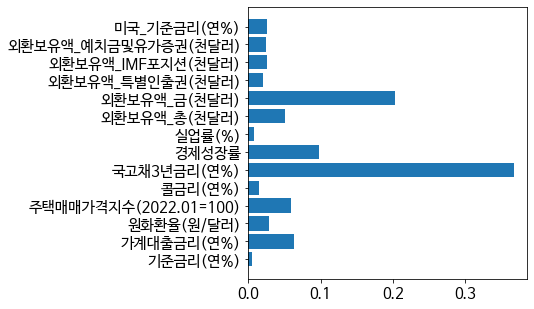

In [30]:
plt.rc('font', family='NanumBarunGothic')
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(5, 5))
plt.barh(importance_series.index, importance_series.values)
plt.show()

 permutation importance(순열중요도)는 데이터 특성상 변수간 상관관계가 높기 때문에, 그리고 값이 바뀌었을 때 비현실적인 데이터가 될 수 있어서 사용하지 않는다.

In [26]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 236 kB/s 
     |████████████████████████████████| 13.1 MB 31.3 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=6ec44bbe8d0c951817ba8ee37cd084eadcb5dabe2e275ba55cc8f17074941347
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=32b497ddfcd2a41a645c8bcbba319ea5ac329e4e713f30c5cf7b21fc4dac3826
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pdpbox sklearn
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [33]:
X_test.columns

Index(['기준금리(연%)', '가계대출금리(연%)', '원화환율(원/달러)', '주택매매가격지수(2022.01=100)',
       '콜금리(연%)', '국고채3년금리(연%)', '경제성장률', '실업률(%)', '외환보유액_총(천달러)',
       '외환보유액_금(천달러)', '외환보유액_특별인출권(천달러)', '외환보유액_IMF포지션(천달러)',
       '외환보유액_예치금및유가증권(천달러)', '미국_기준금리(연%)'],
      dtype='object')

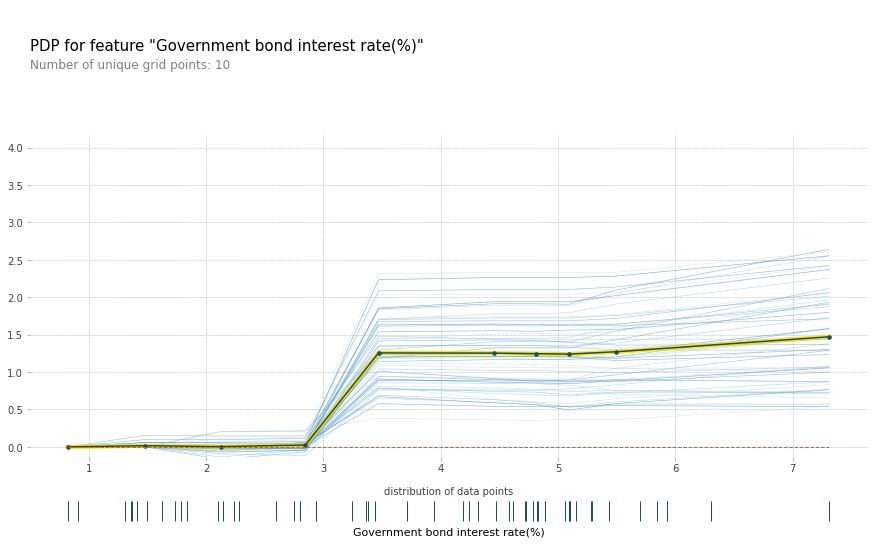

In [55]:
from pdpbox.pdp import pdp_isolate, pdp_plot
target_feature = X_test.columns[5]
isolated = pdp_isolate(
    model=randomforest_tune,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type='percentile',
)
plt.rc('font', family='NanumBarunGothic')
pdp_plot(isolated, feature_name='Government bond interest rate(%)', plot_pts_dist=True, plot_lines=True);

데이터분포가 일정하고, ice plot과 pdp plot이 일관적인 것을 보아,<br>
국채금리가 3% 이상일 때, 물가상승률이 급격하게 오른다고 할 수 있다.

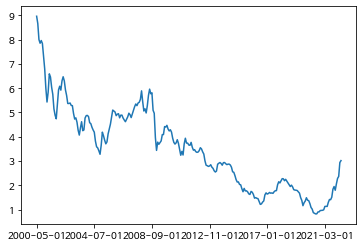

In [57]:
plt.rcParams.update({'font.size': 10})
df.loc[:, target_feature].plot();

그러나 위의 표를 보면 시간에 따라 국채금리가 내려가는 추세임을 볼 수 있어 시간적 요소가 개입했을 가능성이 있고,<br>
또 현재의 국채금리 상승은 물가 인플레이션으로 인한 것이 크기 때문에 원인과 결과가 뒤바뀐 해석 방향일 수 있다.

외환보유액_금(천달러)


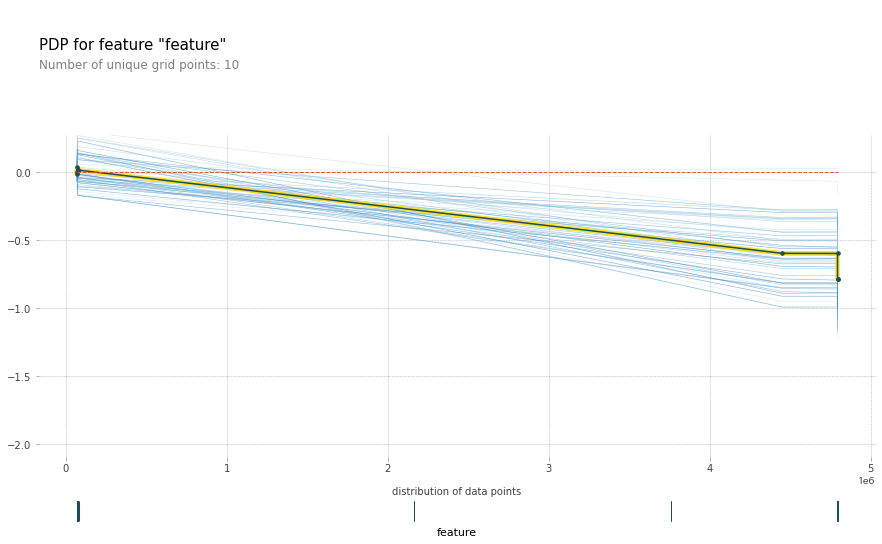

In [58]:
target_feature = X_test.columns[9]
print(target_feature)
isolated = pdp_isolate(
    model=randomforest_tune,
    dataset=X_test,
    model_features=X_test.columns,
    feature=target_feature,
    grid_type='percentile',
)
plt.rc('font', family='NanumBarunGothic')
pdp_plot(isolated, feature_name='feature', plot_pts_dist=True, plot_lines=True);

외환보유액(금)도 많을수록 물가상승률이 낮아지는 모습.<br>
그러나 데이터의 분포가 일정하지 않고,

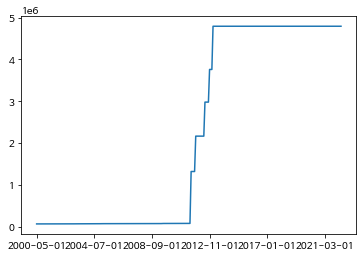

In [59]:
df.loc[:, target_feature].plot();

외환보유액(금)이 2011년을 기점으로 급격하게 증가했기 때문에, 데이터의 신뢰성이 낮다.